In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as mpl
import matplotlib.cm as cm

https://subramgo.github.io/2017/03/13/Quantile-Regression/

In [12]:
assessor_dir = 'datasets/assessorSequential.csv' 
df = pd.read_csv(assessor_dir)

In [13]:
df.head(5)

,Unnamed: 0,Date.Sampled,Address,X1st.Draw,X2nd.Draw,X3rd.Draw,X4th.Draw,X5th.Draw,X6th.Draw,X7th.Draw,...,X11th.Draw,PIN,Township Code,Neighborhood Code,Sale Price,Age,ZIP,Longitude,Latitude,Tract Median Income
0,0,9/4/2019,100XX S BELL AVE,1.52,1.37,1.59,2.53,2.44,1.90,2.45,...,4.35,25-07-311-006-0000,72.0,72271.0,280000.0,94.0,60643-1903,-87.677779,41.710994,122727.0
1,1,7/16/2016,100XX S CALHOUN AVE,3.70,2.62,8.83,13.80,13.20,13.60,12.30,...,2.75,26-07-150-042-0000,70.0,70180.0,NaN,72.0,60617-5354,-87.561811,41.713056,44423.0
2,2,12/17/2019,100XX S CALUMET AVE,4.02,5.35,6.97,6.55,17.70,16.60,12.10,...,8.72,25-10-313-023-0000,70.0,70220.0,NaN,72.0,60628-2122,-87.615468,41.712462,40612.0
3,3,12/14/2019,100XX S CARPENTER ST,9.54,7.31,6.95,5.63,4.91,7.15,12.40,...,7.23,25-08-410-026-0000,72.0,72282.0,NaN,70.0,60643-2248,-87.649387,41.711889,37207.0
4,4,7/14/2021,100XX S CARPENTER ST,14.00,11.00,8.83,8.12,8.69,7.14,11.00,...,NaN,25-08-410-039-0000,72.0,72282.0,NaN,66.0,60643-2248,-87.649360,41.710831,37207.0


In [16]:
df = df.drop(['Unnamed: 0','X11th.Draw'], axis=1)

In [5]:
df.head(5)

,Date.Sampled,Address,median_lead,tract_income
0,9/4/2019,100XX S BELL AVE,2.445,122727.0
1,7/16/2016,100XX S CALHOUN AVE,11.300,44423.0
2,12/17/2019,100XX S CALUMET AVE,11.350,40612.0
3,12/14/2019,100XX S CARPENTER ST,8.425,37207.0
4,12/14/2021,100XX S LASALLE ST,9.650,39787.0


In [17]:
draw_cols = df.columns[2:12]
draw_cols

Index(['X1st.Draw', 'X2nd.Draw', 'X3rd.Draw', 'X4th.Draw', 'X5th.Draw',
       'X6th.Draw', 'X7th.Draw', 'X8th.Draw', 'X9th.Draw', 'X10th.Draw'],
      dtype='object')

In [18]:
df[~df.isin(['NaN', 'NaT']).any(axis=1)]
df.shape
df.dropna(inplace=True)
df.shape

(147, 21)

In [20]:
df['avg_draw'] = df[draw_cols].mean(axis=1)
df = df.drop(columns=draw_cols)

In [22]:
df['tract_income'] = df['Tract Median Income']
df = df.drop(columns=['Tract Median Income'])

Least Absolute Deviation

In [23]:
mod = smf.quantreg('avg_draw ~ tract_income', df)
res = mod.fit(q=.9)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:               avg_draw   Pseudo R-squared:             0.001552
Model:                       QuantReg   Bandwidth:                       4.645
Method:                 Least Squares   Sparsity:                        53.67
Date:                Mon, 24 Apr 2023   No. Observations:                  147
Time:                        14:22:06   Df Residuals:                      145
                                        Df Model:                            1
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       21.5839      3.995      5.403      0.000      13.688      29.480
tract_income -4.271e-05   5.48e-05     -0.779      0.437      -0.000    6.56e-05

The condition number is large, 1.88e+05. This might indicate that there are
strong multicollinearity or other numerical pr

In [25]:
quantiles_ = np.arange(0.05, 0.96, 0.1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['tract_income']] + \
            res.conf_int().loc['tract_income'].tolist()

# fit the model for each quantile
models = [fit_model(x) for x in quantiles_]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('avg_draw ~ tract_income', df).fit()
ols_ci = ols.conf_int().loc['tract_income'].tolist()
ols = dict(a = ols.params['Intercept'],
              b = ols.params['tract_income'],
                lb = ols_ci[0],
                ub = ols_ci[1])

print(models)

      q          a             b        lb        ub
0  0.05   2.196312 -4.331429e-06 -0.000037  0.000028
1  0.15   4.427341 -1.253709e-05 -0.000049  0.000024
2  0.25   4.882029  6.322748e-06 -0.000031  0.000044
3  0.35   7.638846 -1.057648e-05 -0.000050  0.000029
4  0.45   8.037391  5.799491e-06 -0.000036  0.000047
5  0.55   9.302136 -4.129865e-07 -0.000043  0.000042
6  0.65  11.082447 -1.294812e-06 -0.000049  0.000046
7  0.75  13.651401 -1.291631e-05 -0.000070  0.000044
8  0.85  12.433919  2.524385e-05 -0.000043  0.000094
9  0.95  23.702357  2.289669e-05 -0.000294  0.000340


/Users/aakashvardhan/miniforge3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [26]:
print(ols)

{'a': 11.758626604604942, 'b': -1.2526944919313862e-05, 'lb': -8.141915633166188e-05, 'ub': 5.636526649303415e-05}


In [27]:
models.shape[0]

10

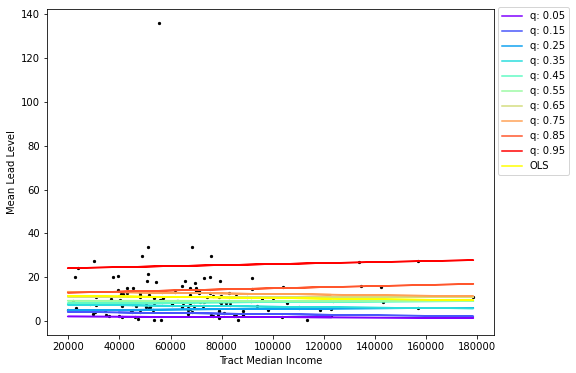

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
colors = cm.rainbow(np.linspace(0, 1, models.shape[0]))

for i in range(models.shape[0]):
    y = models.a[i] + models.b[i] * df.tract_income
    ax.plot(df.tract_income, y, linestyle='solid', color=colors[i],label='q: ' + str(models.q[i].round(2)))



y_ols = ols['a'] + ols['b'] * df.tract_income

ax.plot(df.tract_income, y_ols, color='yellow', label='OLS')

ax.scatter(df.tract_income, df.avg_draw, color='black',s=5)

ax.set_xlabel('Tract Median Income')
ax.set_ylabel('Mean Lead Level')

ax.legend(bbox_to_anchor=(1.18, 1.02))



plt.show()

Quantile:  0.05
                         QuantReg Regression Results                          
Dep. Variable:               avg_draw   Pseudo R-squared:             0.001712
Model:                       QuantReg   Bandwidth:                       5.586
Method:                 Least Squares   Sparsity:                        28.21
Date:                Mon, 24 Apr 2023   No. Observations:                  147
Time:                        14:39:54   Df Residuals:                      145
                                        Df Model:                            1
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.1963      1.234      1.779      0.077      -0.243       4.636
tract_income -4.331e-06   1.66e-05     -0.261      0.794   -3.71e-05    2.84e-05

The condition number is large, 1.88e+05. This might indicate that there are
strong multicollinearity or ot

/Users/aakashvardhan/miniforge3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


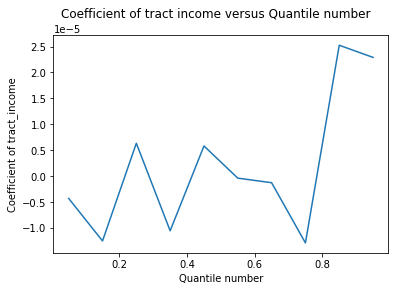

In [35]:
coeff = []
for q in quantiles_:
    q_model = smf.quantreg(formula='avg_draw ~ tract_income',data=df)
    q_model_result = q_model.fit(q=q)
    print("Quantile: ",q)
    print(q_model_result.summary())
    coeff.append(q_model_result.params['tract_income'])

fig = plt.figure()
fig.suptitle('Coefficient of tract income versus Quantile number')
plt.xlabel('Quantile number')
plt.ylabel('Coefficient of tract_income')
plt.plot(quantiles_, coeff)
plt.show()

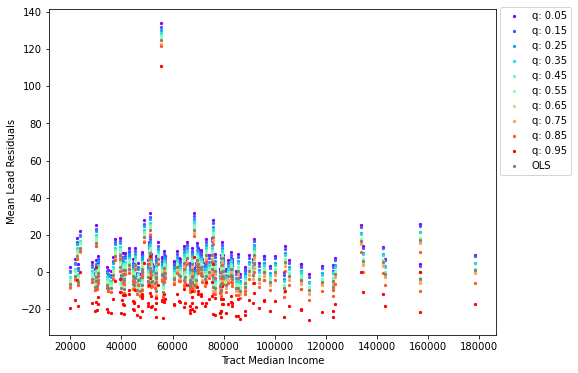

In [31]:
#residual plot for quantile regression
fig, ax = plt.subplots(figsize=(8,6))

for i in range(models.shape[0]):
    y = models.a[i] + models.b[i] * df.tract_income
    ax.scatter(df.tract_income, df.avg_draw - y, color=colors[i], label='q: ' + str(models.q[i].round(2)),s=5)

ax.set_xlabel('Tract Income')
ax.set_ylabel('Residuals')

ax.legend(loc='upper left')


#residual plot for OLS

ax.scatter(df.tract_income, df.avg_draw - y_ols, color='grey', label='OLS',s=5)

ax.set_xlabel('Tract Median Income')
ax.set_ylabel('Mean Lead Residuals')

ax.legend(bbox_to_anchor=(1.18, 1.02))

plt.show()

